In [ ]:
# dirvae.py
# PyTorch implementation of DirVAE (inverse-Gamma CDF approximation) from:
# "Dirichlet Variational Autoencoder" (Joo et al., ICLR 2019)
# Uses Bernoulli decoder for binary images (e.g. MNIST).
#
# Usage: instantiate DirVAE(input_dim, hidden_dim, latent_dim), use loss_fn below,
# then train normally.
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Uniform
EPS = 1e-8
class MLPEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dims, latent_dim):
        super().__init__()
        layers = []
        last = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(last, h))
            layers.append(nn.ReLU(inplace=True))
            last = h
        self.net = nn.Sequential(*layers)
        # output positive concentration parameters \hat{alpha} for each latent dim
        self.alpha_layer = nn.Linear(last, latent_dim)
        self.mu_layer = nn.Linear(last, latent_dim)
        self.logvar_layer = nn.Linear(last, latent_dim)
    def forward(self, x):
        h = self.net(x)
        # softplus to ensure positive alpha_hat; add small bias to avoid zero
        mu = self.mu_layer(h)
        logvar = self.logvar_layer(h)
        alpha_hat = F.softplus(self.alpha_layer(h)) + 1e-6
        alpha_hat = alpha_hat.clamp(min=1e-3, max=50.0)
        return alpha_hat, mu, logvar

class BernoulliDecoder(nn.Module):
    def __init__(self, latent_dim, hidden_dims, output_dim):
        super().__init__()
        layers = []
        last = latent_dim
        for h in hidden_dims:
            layers.append(nn.Linear(last, h))
            layers.append(nn.ReLU(inplace=True))
            last = h
        layers.append(nn.Linear(last, output_dim))
        self.net = nn.Sequential(*layers)
    def forward(self, z):
        logits = self.net(z)
        # return logits (use BCEWithLogitsLoss)
        return logits


class GaussianVAE(nn.Module):
    def __init__(self, input_dim, enc_hidden_dims, dec_hidden_dims, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        self.encoder = MLPEncoder(input_dim, enc_hidden_dims, latent_dim)
        self.decoder = BernoulliDecoder(latent_dim, dec_hidden_dims, input_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        alpha_hat, mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        logits = self.decoder(z)
        return logits, mu, logvar, z

class DirVAE(nn.Module):
    def __init__(self, input_dim, enc_hidden_dims, dec_hidden_dims, latent_dim,
                 prior_alpha=None, beta=1.0):
        """
        input_dim: flattened input size (e.g. 28*28)
        enc_hidden_dims: list of encoder hidden sizes
        dec_hidden_dims: list of decoder hidden sizes
        latent_dim: K
        prior_alpha: vector or scalar for Dirichlet prior concentration alpha (if scalar, replicate)
        beta: rate parameter for Gammas (paper uses beta=1)
        """
        super().__init__()
        self.latent_dim = latent_dim
        self.encoder = MLPEncoder(input_dim, enc_hidden_dims, latent_dim)
        self.decoder = BernoulliDecoder(latent_dim, dec_hidden_dims, input_dim)
        if prior_alpha is None:
            # default weak symmetric prior; user can override
            prior_alpha = torch.ones(latent_dim) * 0.98
        elif torch.is_tensor(prior_alpha):
            if prior_alpha.numel() == 1:
                prior_alpha = prior_alpha.repeat(latent_dim)
        else:
            # numeric scalar
            prior_alpha = torch.tensor(float(prior_alpha)).repeat(latent_dim)
        self.register_buffer('prior_alpha', prior_alpha.float())
        self.beta = float(beta)
    def inverse_gamma_cdf_approx(self, u, alpha):
        """
        Approximate inverse CDF for X ~ Gamma(alpha, beta) using:
        F^{-1}(u; alpha, beta) ≈ beta^{-1} * (u * alpha * Gamma(alpha))^{1/alpha}
        u: uniform samples in (0,1), shape (batch, K)
        alpha: shape (batch, K) or (K,)
        returns: approx gamma samples shape (batch, K)
        """
        # alpha * Gamma(alpha) = alpha * exp(lgamma(alpha))
        # note: torch.lgamma for log Gamma
        # shapes broadcast
        log_gamma = torch.lgamma(alpha)
        a_gamma = alpha * torch.exp(log_gamma)  # shape (batch, K)
        # clamp u to (eps, 1)
        u = u.clamp(min=EPS, max=1.0 - 1e-12)
        base = u * a_gamma
        # to avoid negative/zero values due to numerical issues, clamp base
        base = base.clamp(min=EPS)
        # power 1/alpha
        samples = (base) ** (1.0 / alpha)
        # divide by beta (rate)
        samples = samples / (self.beta + 0.0)
        return samples
    def sample_dirichlet_from_alpha(self, alpha_hat):
        """
        Given alpha_hat (batch, K), produce reparam samples z on simplex:
          1) draw u ~ Uniform(0,1) per component
          2) approximate gamma sample via inverse Gamma CDF approx
          3) normalize v -> z = v / sum_k v_k
        Returns z (batch, K), v (batch, K), u (for reproducibility)
        """
        batch = alpha_hat.shape[0]
        # Uniform draws per component
        u = torch.rand_like(alpha_hat)  # Uniform(0,1)
        v = self.inverse_gamma_cdf_approx(u, alpha_hat)
        # Normalize to get Dirichlet sample
        denom = v.sum(dim=1, keepdim=True).clamp(min=EPS)
        z = v / denom
        return z, v, u
    def forward(self, x):
        """
        x: flattened input (batch, input_dim) with values in [0,1] for Bernoulli decoding
        returns: reconstruction logits, z, alpha_hat, v
        """
        alpha_hat, mu, logvar = self.encoder(x)  # (batch, K)
        z, v, u = self.sample_dirichlet_from_alpha(alpha_hat)  # z in simplex
        logits = self.decoder(z)  # (batch, input_dim)
        return logits, z, alpha_hat, v
def multi_gamma_kl(alpha_hat, prior_alpha, reduction='batchmean'):
    """
    KL between MultiGamma(alpha_hat, beta=1) and MultiGamma(prior_alpha, beta=1)
    Per paper (Equation 3):
      KL(Q||P) = sum_k [ log Gamma(alpha_k) - log Gamma(alpha_hat_k) + (alpha_hat_k - alpha_k) * psi(alpha_hat_k) ]
    alpha_hat: (batch, K)
    prior_alpha: (K,) or (batch, K)
    reduction: 'batchmean', 'sum', 'none'
    Returns scalar KL (averaged over batch if batchmean)
    """
    # broadcast prior_alpha to batch if necessary
    if prior_alpha.dim() == 1:
        prior = prior_alpha.unsqueeze(0).expand_as(alpha_hat)
    else:
        prior = prior_alpha
    term1 = torch.lgamma(prior) - torch.lgamma(alpha_hat)
    term2 = (alpha_hat - prior) * torch.digamma(alpha_hat)
    kl_comp = term1 + term2
    kl = kl_comp.sum(dim=1)  # per example sum over K
    if reduction == 'batchmean':
        return kl.mean()
    elif reduction == 'sum':
        return kl.sum()
    else:
        return kl  # per example
def dirvae_elbo_loss(model, x, reduction='mean'):
    """
    Compute negative ELBO (loss to minimize) for Bernoulli decoder.
    x: (batch, input_dim) values in {0,1} or [0,1]
    returns loss (scalar), recon_loss (scalar), kl (scalar)
    """
    logits, z, alpha_hat, v = model(x)
    # Reconstruction: bernoulli likelihood -> BCEWithLogits
    bce = F.binary_cross_entropy_with_logits(logits, x, reduction='none')
    recon_per_sample = bce.sum(dim=1)  # per example reconstruction negative log-likelihood
    if reduction == 'mean':
        recon_loss = recon_per_sample.mean()
    else:
        recon_loss = recon_per_sample.sum()
    # KL between MultiGamma post (alpha_hat) and prior MultiGamma (prior_alpha)
    kl = multi_gamma_kl(alpha_hat, model.prior_alpha, reduction='batchmean')
    # ELBO = E_q[log p(x|z)] - KL -> loss = -ELBO = recon_loss + KL
    loss = recon_loss + kl
    return loss, recon_loss, kl


def gaussian_vae_elbo_loss(model, x, reduction='mean'):
    """
    Negative ELBO for Gaussian VAE with Bernoulli likelihood.
    """
    logits, mu, logvar, z = model(x)

    # Reconstruction loss
    bce = F.binary_cross_entropy_with_logits(logits, x, reduction='none')
    recon_per_sample = bce.sum(dim=1)
    if reduction == 'mean':
        recon_loss = recon_per_sample.mean()
    else:
        recon_loss = recon_per_sample.sum()

    # KL divergence between q(z|x) and N(0, I)
    kl_per_sample = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
    if reduction == 'mean':
        kl = kl_per_sample.mean()
    else:
        kl = kl_per_sample.sum()

    loss = recon_loss + kl
    return loss, recon_loss, kl



# ----------------------------
# Example training loop skeleton
# ----------------------------
if __name__ == "__main__":
    # Quick usage example for MNIST-like data (flattened, binary)
    import torchvision
    import torchvision.transforms as T
    from torch.utils.data import DataLoader
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Simple binarization transform
    transform = T.Compose([T.ToTensor(), lambda t: (t > 0.5).float(), lambda t: t.view(-1)])
    trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    loader = DataLoader(trainset, batch_size=100, shuffle=True, num_workers=0)
    input_dim = 28 * 28
    latent_dim = 50



    model_DIR = DirVAE(input_dim=input_dim,
                   enc_hidden_dims=[500,500],
                   dec_hidden_dims=[500],
                   latent_dim=latent_dim,
                   prior_alpha=0.98).to(device)
    optimizer_DIR = torch.optim.Adam(model_DIR.parameters(), lr=1e-3)
    for epoch in range(1, 50):
        model_DIR.train()
        tot_loss = 0.0
        tot_recon = 0.0
        tot_kl = 0.0
        samlet=0

        for xb, _ in loader:
            xb = xb.to(device)
            optimizer_DIR.zero_grad()
            loss, recon, kl = dirvae_elbo_loss(model_DIR, xb, reduction='mean')
            loss.backward()
            optimizer_DIR.step()
            tot_loss += loss.item() * xb.size(0)
            tot_recon += recon.item() * xb.size(0)
            tot_kl += kl.item() * xb.size(0)

        n = len(loader.dataset)
        print(f"Epoch {epoch:02d} DIR Loss {tot_loss/n:.4f} Recon {tot_recon/n:.4f} KL {tot_kl/n:.4f}")


    model_GAU = GaussianVAE(input_dim, [500, 500], [500], latent_dim).to(device)
    optimizer_GAU = torch.optim.Adam(model_GAU.parameters(), lr=1e-3)

    for epoch in range(1, 50):
        model_GAU.train()
        tot_loss = tot_recon = tot_kl = 0.0
        for xb, _ in loader:
            xb = xb.to(device)
            optimizer_GAU.zero_grad()
            loss, recon, kl = gaussian_vae_elbo_loss(model_GAU, xb, reduction='mean')
            loss.backward()
            optimizer_GAU.step()
            tot_loss += loss.item() * xb.size(0)
            tot_recon += recon.item() * xb.size(0)
            tot_kl += kl.item() * xb.size(0)

        n = len(loader.dataset)
        print(f"Epoch {epoch:02d} GAUSS| Loss {tot_loss/n:.4f} | Recon {tot_recon/n:.4f} | KL {tot_kl/n:.4f}")


Epoch 01 DIR Loss 223.0219 Recon 222.9601 KL 0.0618
Epoch 02 DIR Loss 206.2738 Recon 206.1721 KL 0.1018
Epoch 03 DIR Loss 197.4914 Recon 194.7259 KL 2.7655
Epoch 04 DIR Loss 189.5804 Recon 186.1164 KL 3.4641
Epoch 05 DIR Loss 180.4950 Recon 175.0129 KL 5.4822
Epoch 06 DIR Loss 170.7518 Recon 163.7647 KL 6.9871
Epoch 07 DIR Loss 165.1088 Recon 157.3195 KL 7.7893
Epoch 08 DIR Loss 157.5810 Recon 148.0734 KL 9.5076
Epoch 09 DIR Loss 148.5084 Recon 137.1980 KL 11.3105
Epoch 10 DIR Loss 142.2416 Recon 129.5971 KL 12.6445
Epoch 11 DIR Loss 137.2778 Recon 123.5895 KL 13.6883
Epoch 12 DIR Loss 133.3313 Recon 118.7674 KL 14.5640
Epoch 13 DIR Loss 130.0015 Recon 114.6853 KL 15.3162
Epoch 14 DIR Loss 126.9855 Recon 110.9866 KL 15.9989
Epoch 15 DIR Loss 124.6014 Recon 108.0342 KL 16.5672
Epoch 16 DIR Loss 122.5794 Recon 105.5763 KL 17.0031
Epoch 17 DIR Loss 120.9012 Recon 103.4627 KL 17.4385
Epoch 18 DIR Loss 119.2767 Recon 101.5501 KL 17.7266
Epoch 19 DIR Loss 117.9141 Recon 99.8634 KL 18.0507
Ep

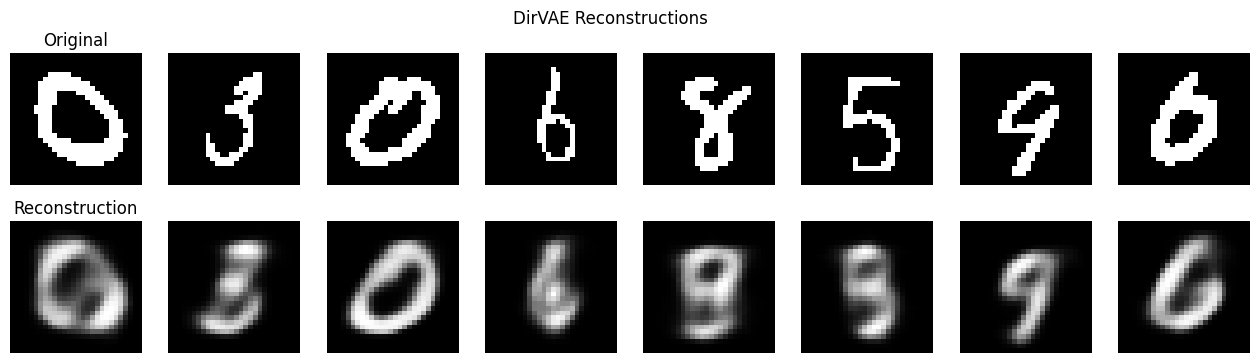

Computing t-SNE projection of latent space...


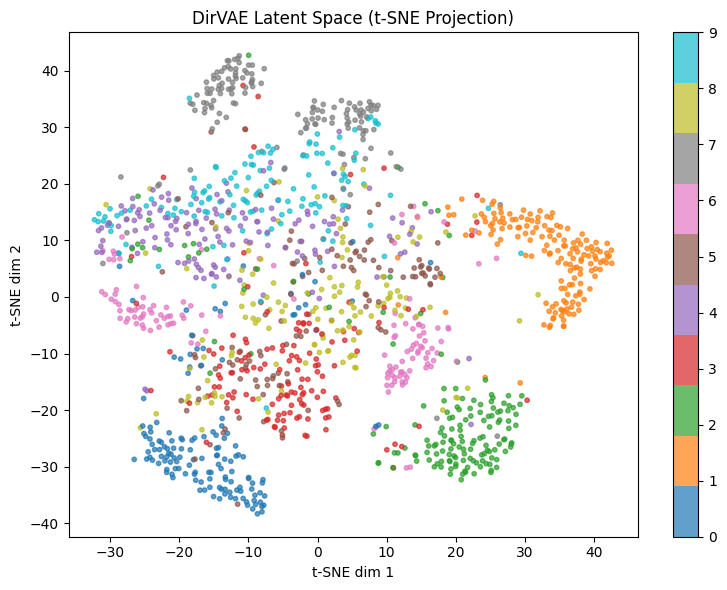

In [20]:
    import matplotlib.pyplot as plt
    from sklearn.manifold import TSNE
    import numpy as np
    model=model_DIR
    # -----------------------------
    # Plot some reconstructions
    # -----------------------------
    model.eval()
    xb, yb = next(iter(loader))
    xb = xb.to(device)
    with torch.no_grad():
        logits, z, _, _ = model(xb)
        recon = torch.sigmoid(logits)

    xb = xb.cpu().numpy()
    recon = recon.cpu().numpy()

    n = 8  # number of samples to show
    plt.figure(figsize=(2*n, 4))
    for i in range(n):
        # Original
        plt.subplot(2, n, i + 1)
        plt.imshow(xb[i].reshape(28, 28), cmap="gray")
        plt.axis("off")
        if i == 0:
            plt.title("Original")

        # Reconstruction
        plt.subplot(2, n, n + i + 1)
        plt.imshow(recon[i].reshape(28, 28), cmap="gray")
        plt.axis("off")
        if i == 0:
            plt.title("Reconstruction")

    plt.suptitle("DirVAE Reconstructions")
    plt.show()

    # -----------------------------
    # Visualize latent space (t-SNE)
    # -----------------------------
    print("Computing t-SNE projection of latent space...")

    # Collect a batch of latent representations
    z_all = []
    y_all = []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            _, z, _, _ = model(xb)
            z_all.append(z.cpu())
            y_all.append(yb)
            if len(z_all) > 10:  # limit to ~1280 samples
                break

    z_all = torch.cat(z_all, dim=0).numpy()
    y_all = torch.cat(y_all, dim=0).numpy()

    # t-SNE to 2D
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    z_2d = tsne.fit_transform(z_all)

    # Plot t-SNE
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(z_2d[:, 0], z_2d[:, 1], c=y_all, cmap="tab10", s=10, alpha=0.7)
    plt.colorbar(scatter, ticks=range(10))
    plt.title("DirVAE Latent Space (t-SNE Projection)")
    plt.xlabel("t-SNE dim 1")
    plt.ylabel("t-SNE dim 2")
    plt.tight_layout()
    plt.show()
